This notebook illustrates experiments using baseline models built on purpose.

# Imports

We will use the following libraries:
- **Pandas**: a data manipulation & analysis library ([documentation](https://pandas.pydata.org/docs/reference/index.html)) - *for efficient data reading/manipulation*
- **Spacy**: a modern NLP library ([documentation](https://spacy.io/api)) - *for base preprocessing such as tokenization*
- **Scikit-learn**: a machine learning library ([documentation](https://scikit-learn.org/stable/modules/classes.html)) - *for data splitting, feature extraction, model building, and evaluation*
- **Matplotlib**: a visualization library ([documentation](https://matplotlib.org/stable/api/index.html)) - *for making plots about our data*
- Other standard python libraries such as **re** ([documentation](https://docs.python.org/3/library/re.html)) - *for matching sensible data for anonymization*

In [ ]:
# Install spacy and the associated Italian model
!pip install -U spacy
!python -m spacy download en_core_web_sm

# Import the needed libraries (and their functions)
import matplotlib.pyplot as plt
import pandas as pd
import re
import spacy
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, plot_confusion_matrix
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from spacy.language import Language
from spacy.matcher import Matcher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 8.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Load the dataset

First, we define where our data splits are located.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Define the filepath to your dataset splits
TRAIN_FILEPATHS = [
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-en_1.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-en_2.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-en_3.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-en_4.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/train-en_5.tsv"]
TEST_FILEPATHS = [
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-en_1.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-en_2.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-en_3.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-en_4.tsv",
  "/content/drive/MyDrive/Colab Notebooks/experiments_final/data/test-en_5.tsv"]

Then, we load these data splits and append them to dedicated lists to ease their subsequent retrieval.

In [ ]:
K_SPLITS = 5    # define the number of files/iterations for k-fold cross-validation
train_sets = [] # initialize a list that will contain the training sets
test_sets = []  # initialize a list that will contain the test sets

# Load the K_SPLITS (tab-separated: \t) data splits into pandas dataframes,
# then add them to the respective train/test sets lists
for i in range(K_SPLITS):
  curr_train_set = pd.read_csv(TRAIN_FILEPATHS[i], delimiter='\t', names=["label", "tweet"])
  curr_test_set = pd.read_csv(TEST_FILEPATHS[i], delimiter='\t', names=["label", "tweet"])
  train_sets.append(curr_train_set)
  test_sets.append(curr_test_set)

# Preprocess the dataset

Our data is already preprocessed (e.g., anonymization; see notebook *1_preprocessing-en.ipynb*).

However, we will work on tokens as our units of linguistic information. To do that, we need to tokenize the text.

In [ ]:
# First, define the functions and classes that we need to do that

# 1) Function that creates the merger of placeholder tokens component
@Language.factory("placeholder_merger")
def create_placeholder_merger(nlp, name):
  return PlaceholderMerger(nlp.vocab)

# 2) Actual definition of the placeholder merger component
class PlaceholderMerger:
  def __init__(self, vocab):
    # Define a pattern matcher (to merge "[", "USER"/"URL", "]" into a single token)
    patterns = [
      [{"ORTH": "["}, {"ORTH": "USER"}, {"ORTH": "]"}],
      [{"ORTH": "["}, {"ORTH": "URL"}, {"ORTH": "]"}],
    ]
    self.matcher = Matcher(vocab)
    self.matcher.add("PlaceholderMerger", patterns)

  def __call__(self, doc):
    matches = self.matcher(doc)
    spans = []
    for match_id, start, end in matches:
      spans.append(doc[start:end])
    with doc.retokenize() as retokenizer:
      for span in spans:
        retokenizer.merge(span)
    return doc

# 3) Define the function that will retrieve tokens
def get_tokenized_tweet(text):
  doc = nlp(text) # create a doc object for the raw text of the tweet

  # Iterate over the tokens adding them to a "tokens" list
  tokens = []
  for token in doc:
    tokens.append(token.text)
  return tokens

# Load the spacy model for Italian and add placeholder merger component
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("placeholder_merger", last=True)

# Iterate through the splits to preprocess them
for i in range(K_SPLITS):
  # Do the actual tokenization on the "tweet" column of the dataframe
  # Store the results on the "tweet_tokens" column
  train_sets[i]['tweet_tokens'] = list(map(get_tokenized_tweet, train_sets[i].tweet))
  test_sets[i]['tweet_tokens'] = list(map(get_tokenized_tweet, test_sets[i].tweet))
  
train_sets[0].head(10)  # print the first 10 elements of the first training split just for seeing the data

# Note: if this snippet gives you an error, you have to reset and restart colab
# Top bar: "Runtime" -> "Restart runtime"

,label,tweet,tweet_tokens
0,NOT ABUSIVE,not if you keep telling people killing protest...,"[not, if, you, keep, telling, people, killing,..."
1,NOT ABUSIVE,we have the opportunity to pass recovery legis...,"[we, have, the, opportunity, to, pass, recover..."
2,NOT ABUSIVE,[USER] i live in ikotun and i can tell you tha...,"[[USER], i, live, in, ikotun, and, i, can, tel..."
3,NOT ABUSIVE,my cousin asked her dad (my liberal but boomer...,"[my, cousin, asked, her, dad, (, my, liberal, ..."
4,NOT ABUSIVE,[USER] depends on why they are moving. usually...,"[[USER], depends, on, why, they, are, moving, ..."
5,NOT ABUSIVE,"orthodox rabbis in us, israel tell followers t...","[orthodox, rabbis, in, us, ,, israel, tell, fo..."
6,NOT ABUSIVE,[USER] [USER] [USER] neither would catholics,"[[USER], [USER], [USER], neither, would, catho..."
7,NOT ABUSIVE,"according to the piece in the sunday times , t...","[according, to, the, piece, in, the, sunday, t..."
8,NOT ABUSIVE,[USER] [USER] [USER] my brother the quran are ...,"[[USER], [USER], [USER], my, brother, the, qur..."
9,NOT ABUSIVE,[USER] [USER] [USER] [USER] what the hell do u...,"[[USER], [USER], [USER], [USER], what, the, he..."


# Explore the dataset

Getting into data before delving into more complex modeling decisions is crucial to understand what we are manipulating.

Summary statistics have already been computed when creating the splits (see notebook *1_preprocessing-en.ipynb*)

### Token-level statistics

Compute the vocabulary size (unique tokens) as well as statistics about length of tweets.

In [ ]:
tokens = Counter()        # this stores the tokens and their count
token_lengths = []        # this stores the token lengths of all tweets

# Note: we will do the following twice: one for the train set, and one for the
# test set. This is because train+test will produce the results for the whole
# dataset (for simplicity, we use the first split (0), but other splits would
# produce exactly the same results - each train+test split has the same examples)

# rows (first element) are number of examples
tot_examples = train_sets[0].shape[0] + test_sets[0].shape[0]
print(f"Tot examples: {tot_examples}")

# TRAINING SET
# Iterate over all the training examples (all rows)
for index, row in train_sets[0].iterrows():
  curr_tweet = row["tweet"]               # get the "tweet" col of the current example
  curr_tokens = row["tweet_tokens"]       # get the "tweet_tokens" col of the current example
  token_lengths.append(len(curr_tokens))  # append the count of tokens to the lengths list

  # Iterate over each token of the i-th examples to store occurrences of tokens
  for curr_token in curr_tokens:
    curr_token = str(curr_token)
    if curr_token in tokens:
      tokens[curr_token] += 1
    else:
      tokens[curr_token] = 1

# TEST SET
# Iterate over all the test examples (all rows)
for index, row in test_sets[0].iterrows():
  curr_tweet = row["tweet"]               # get the "tweet" col of the current example
  curr_tokens = row["tweet_tokens"]       # get the "tweet_tokens" col of the current example
  token_lengths.append(len(curr_tokens))  # append the count of tokens to the lengths list

  # Iterate over each token of the i-th examples to store occurrences of tokens
  for curr_token in curr_tokens:
    curr_token = str(curr_token)
    if curr_token in tokens:
      tokens[curr_token] += 1
    else:
      tokens[curr_token] = 1

print(f"Vocabulary size: {len(tokens)}")
print(f"Min token length: {min(token_lengths)}")
print(f"Max token length: {max(token_lengths)}")
print(f"Avg token length: {round(sum(token_lengths)/tot_examples, 2)}")

Tot examples: 7028
Vocabulary size: 20485
Min token length: 2
Max token length: 114
Avg token length: 34.89


# Models

We will experiment with simple baselines and more elaborated models to compare performance and gauge the level of difficulty of our task.

We keep track of scores of all models on a dictionary, in order to easily plot/compare results at the end of this notebook.

In [ ]:
# This variable will store the performance of all models
model_scores = dict()

## Always abusive baseline

Probably the most trivial one, this baseline always predict a tweet as abusive.

In [ ]:
#Import metrics
from sklearn.metrics import recall_score, precision_score

# Initialize the results dictionary
model_scores["always-abusive"] = {}
model_scores["always-abusive"]["accuracy"] = {}
model_scores["always-abusive"]["macro_f1"] = {}
model_scores["always-abusive"]["recall"] = {}
model_scores["always-abusive"]["precision"] = {}

# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Generate a list of "ABUSIVE" predictions (the length must be the same of the number of test examples)
  predictions = []
  for i in range(test_sets[j].shape[0]):
    predictions.append("ABUSIVE")
  
  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(test_sets[j]["label"], predictions)
  macro_f1 = f1_score(test_sets[j]["label"], predictions, average='macro')
  precision = precision_score(test_sets[j]["label"], predictions, average='macro')
  recall = recall_score(test_sets[j]["label"], predictions, average='macro')

  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Add results to the results dictionary
  if len(model_scores["always-abusive"]["accuracy"]) == 0:
    model_scores["always-abusive"]["accuracy"] = [accuracy]
    model_scores["always-abusive"]["macro_f1"] = [macro_f1]
    model_scores["always-abusive"]["precision"] = [precision]
    model_scores["always-abusive"]["recall"] = [recall]

  else:
    model_scores["always-abusive"]["accuracy"].append(accuracy)
    model_scores["always-abusive"]["macro_f1"].append(macro_f1)
    model_scores["always-abusive"]["precision"].append(precision)
    model_scores["always-abusive"]["recall"].append(recall)


Split 1
- Accuracy 0.14295874822190613
- Macro F1 0.12507778469197262
- Precision 0.07147937411095306
- Recall 0.5

Split 2
- Accuracy 0.14366998577524892
- Macro F1 0.12562189054726366
- Precision 0.07183499288762446
- Recall 0.5

Split 3
- Accuracy 0.14366998577524892
- Macro F1 0.12562189054726366
- Precision 0.07183499288762446
- Recall 0.5

Split 4
- Accuracy 0.14306049822064057
- Macro F1 0.12515566625155666
- Precision 0.07153024911032028
- Recall 0.5

Split 5
- Accuracy 0.14306049822064057
- Macro F1 0.12515566625155666
- Precision 0.07153024911032028
- Recall 0.5



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

## Always not abusive baseline

Similarly to the previous one, this baseline always predict a tweet as not abusive.

In [ ]:
# Initialize the results dictionary
model_scores["always-not-abusive"] = {}
model_scores["always-not-abusive"]["accuracy"] = {}
model_scores["always-not-abusive"]["macro_f1"] = {}
model_scores["always-not-abusive"]["precision"] = {}
model_scores["always-not-abusive"]["recall"] = {}


# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Generate a list of "NOT-ABUSIVE" predictions (the length must be the same of the number of test examples)
  predictions = []
  for i in range(test_sets[j].shape[0]):
    predictions.append("NOT ABUSIVE")

  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(test_sets[j]["label"], predictions)
  macro_f1 = f1_score(test_sets[j]["label"], predictions, average='macro')
  precision = precision_score(test_sets[j]["label"], predictions, average='macro')
  recall = recall_score(test_sets[j]["label"], predictions, average='macro')


  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Add results to the results dictionary
  if len(model_scores["always-not-abusive"]["accuracy"]) == 0:
    model_scores["always-not-abusive"]["accuracy"] = [accuracy]
    model_scores["always-not-abusive"]["macro_f1"] = [macro_f1]
    model_scores["always-not-abusive"]["precision"] = [precision]
    model_scores["always-not-abusive"]["recall"] = [recall]

  else:
    model_scores["always-not-abusive"]["accuracy"].append(accuracy)
    model_scores["always-not-abusive"]["macro_f1"].append(macro_f1)
    model_scores["always-not-abusive"]["precision"].append(precision)
    model_scores["always-not-abusive"]["recall"].append(recall)


Split 1
- Accuracy 0.8570412517780939
- Macro F1 0.461509000382995
- Precision 0.42852062588904694
- Recall 0.5

Split 2
- Accuracy 0.8563300142247511
- Macro F1 0.4613026819923372
- Precision 0.42816500711237554
- Recall 0.5

Split 3
- Accuracy 0.8563300142247511
- Macro F1 0.4613026819923372
- Precision 0.42816500711237554
- Recall 0.5

Split 4
- Accuracy 0.8569395017793594
- Macro F1 0.4614794940590264
- Precision 0.4284697508896797
- Recall 0.5

Split 5
- Accuracy 0.8569395017793594
- Macro F1 0.4614794940590264
- Precision 0.4284697508896797
- Recall 0.5



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Pr

## Random baseline

A random baseline simply predict a labels (drawn from a predefined set) at random. 

This baseline represents a good starting point to determine if more complex models actually learn something about the task.

In [ ]:
import random     # import the standard library for pseudorandom number generators
random.seed(42)   # ensures you will get the same results if you run this code twice or more times

# Initialize the results dictionary
model_scores["random"] = {}
model_scores["random"]["accuracy"] = {}
model_scores["random"]["macro_f1"] = {}
model_scores["random"]["precision"] = {}
model_scores["random"]["recall"] = {}

# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Generate a list of 0,1 values (the length must be the same of the number of test examples)
  # These will be used as predictions for the elements on the test set
  raw_predictions = []
  for i in range(test_sets[j].shape[0]):
    raw_predictions.append(random.randint(0,1))

  # Convert them to our labels (1 -> ABUS; 0 -> NOT-ABUSIVE)
  predictions = ["ABUSIVE" if p==1 else "NOT ABUSIVE" for p in raw_predictions]

  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(test_sets[j]["label"], predictions)
  macro_f1 = f1_score(test_sets[j]["label"], predictions, average='macro')
  precision = precision_score(test_sets[j]["label"], predictions, average='macro')
  recall = recall_score(test_sets[j]["label"], predictions, average='macro')

  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Add results to the results dictionary
  if len(model_scores["random"]["accuracy"]) == 0:
    model_scores["random"]["accuracy"] = [accuracy]
    model_scores["random"]["macro_f1"] = [macro_f1]
    model_scores["random"]["precision"] = [precision]
    model_scores["random"]["recall"] = [recall]

  else:
    model_scores["random"]["accuracy"].append(accuracy)
    model_scores["random"]["macro_f1"].append(macro_f1)
    model_scores["random"]["precision"].append(precision)
    model_scores["random"]["recall"].append(recall)


Split 1
- Accuracy 0.48933143669985774
- Macro F1 0.41938652734354337
- Precision 0.49644037707509725
- Recall 0.4927396213950992

Split 2
- Accuracy 0.49857752489331436
- Macro F1 0.43211446740858506
- Precision 0.5087219957513938
- Recall 0.51770912141048

Split 3
- Accuracy 0.5213371266002845
- Macro F1 0.4510829683025037
- Precision 0.5203235499438492
- Recall 0.5412979836189599

Split 4
- Accuracy 0.4903914590747331
- Macro F1 0.4127049735420082
- Precision 0.48556187882030577
- Recall 0.4705624700418175

Split 5
- Accuracy 0.4825622775800712
- Macro F1 0.4179860866176145
- Precision 0.49958264281536363
- Recall 0.49915084048197544



## Logistic regression

Logistic regression is a supervised machine learning algorithm for classification. 

We here extract features, implement the model, and evaluate it.

### Feature extraction

Computers understand numbers, but we are actually working with words. 

We need to convert our texts to numbers, and use derived **features** (e.g., tokens) in our model.

Indeed, differently from previous baselines, here we will use the training set to extract features and "train" a model to identify hate speech.

As typical convention, X represents inputs (e.g., representations of tweets) and y represents outputs (e.g., labels).

In [ ]:
# Prepare lists for training and test tweets and labels
# There will be K objects for each list, since we have K splits
X_training = []
X_test = []
y_training = []
y_test = []

# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Create a list of lists for each set.
  # Inner lists are tokens corresponding to the i-th tweet
  training_data_tokens = [x for x in train_sets[j]["tweet_tokens"]]
  test_data_tokens = [x for x in test_sets[j]["tweet_tokens"]]

  # Convert tweets to a matrix of token counts
  # These will serve as our features
  vectorizer = CountVectorizer(
      binary=True,
      tokenizer=lambda x: x,    # override tokenizer (we already have tokens)
      preprocessor=lambda x: x  # override preprocessor (we already preprocessed our data)
  )

  # Fit to training data, then transform it (standardization by centering and scaling)
  # The standardization applies to test set too (no fitting there)
  X_training.append(vectorizer.fit_transform(training_data_tokens))
  X_test.append(vectorizer.transform(test_data_tokens))

  # Get the list of labels for each set
  y_training.append(train_sets[j]['label'])
  y_test.append(test_sets[j]['label'])

### Training, prediction and analysis

Now that we defined our features, we need to fit the model using training data.

We can then use our model to predict unseen data (the test set) and compute performance scores.

Split 1
- Accuracy 0.8477951635846372
- Macro F1 0.5886078372391916
- Precision 0.6516000784895873
- Recall 0.5733655374579385



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


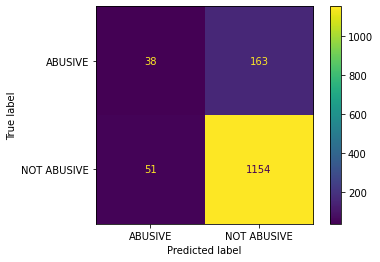

Split 2
- Accuracy 0.8549075391180654
- Macro F1 0.6216142054299358
- Precision 0.6864241960183768
- Recall 0.6001077267195158



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


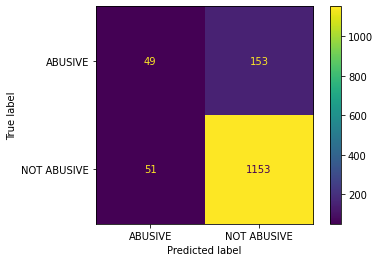

Split 3
- Accuracy 0.8513513513513513
- Macro F1 0.5815208026260512
- Precision 0.6635562233909341
- Recall 0.5671318377684944



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


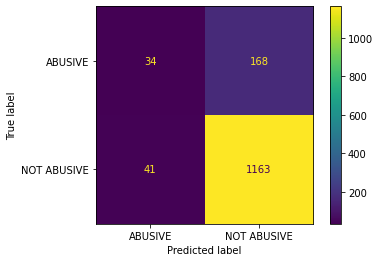

Split 4
- Accuracy 0.8640569395017793
- Macro F1 0.6199739714989329
- Precision 0.7228952910942361
- Recall 0.5953331349895044



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


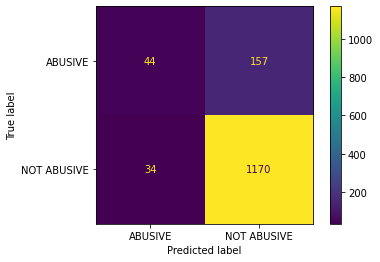

Split 5
- Accuracy 0.8462633451957295
- Macro F1 0.5872458028224183
- Precision 0.6467668556709653
- Recall 0.572517396406671



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


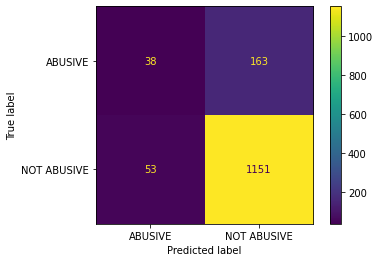

In [ ]:
# Initialize the results dictionary
model_scores["logistic-regression"] = {}
model_scores["logistic-regression"]["accuracy"] = {}
model_scores["logistic-regression"]["macro_f1"] = {}
model_scores["logistic-regression"]["precision"] = {}
model_scores["logistic-regression"]["recall"] = {}


# Do the following K times (for all splits)
for j in range(K_SPLITS):
  # Fit the model according to the given training data
  # Namely, using training X and y
  model = LogisticRegression().fit(X_training[j], y_training[j])

  # Make predictions on test data using the fitted model
  y_pred = model.predict(X_test[j])

  # Compare the predictions to the actual values on the test set and print results
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average='macro')
  precision = precision_score(y_test[j], y_pred, average='macro')
  recall = recall_score(y_test[j], y_pred, average='macro')


  # Print results for the current split
  print("Split", j+1)
  print("- Accuracy", accuracy)
  print("- Macro F1", macro_f1)
  print("- Precision", precision)
  print("- Recall", recall)

  print()

  # Plot a confusion matrix for the fitted model
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["logistic-regression"]["accuracy"]) == 0:
    model_scores["logistic-regression"]["accuracy"] = [accuracy]
    model_scores["logistic-regression"]["macro_f1"] = [macro_f1]
    model_scores["logistic-regression"]["precision"] = [precision]
    model_scores["logistic-regression"]["recall"] = [recall]

  else:
    model_scores["logistic-regression"]["accuracy"].append(accuracy)
    model_scores["logistic-regression"]["macro_f1"].append(macro_f1)
    model_scores["logistic-regression"]["precision"].append(precision)
    model_scores["logistic-regression"]["recall"].append(recall)


### Most important features

In [ ]:
# Define the function that will return the top features learnt by the model
def extract_features(model, vectorizer):
  ranked_features = []
  coeff = model.coef_[0]
  id_to_token = {}

  for key, value in vectorizer.vocabulary_.items():
    id_to_token[value] = key

  tuples = []
  for i in range(len(coeff)):
    tuples.append((id_to_token[i], coeff[i]))
  tuples.sort(key=lambda x: -x[1])

  for tup in tuples:
    ranked_features.append(tup)

  return ranked_features

# Get the coefficients of each feature
ranked_features = extract_features(model, vectorizer)
ranked_features = ranked_features[::-1]

# Print the top 50 features
for i in range(50):
  print(f"{ranked_features[i][1]}\t{ranked_features[i][0]}")

-2.318037371525974	fuck
-1.9632564705717044	fucking
-1.86321501994068	kill
-1.7571518314760393	fake
-1.7463700801610473	ass
-1.702426098170554	shit
-1.585902021987954	rape
-1.5241319815974996	stupid
-1.4685945612010185	hating
-1.4363085454857805	representation
-1.430385500671711	disgusting
-1.3994321646122987	terrorist
-1.3180878632741941	assholes
-1.292557752984845	biggest
-1.2337102500915489	pedophiles
-1.211524241810213	scum
-1.1962919068955644	asshole
-1.1865556610939758	yourself
-1.1799705680534933	dumb
-1.1759908474454734	cult
-1.1746419413488154	burn
-1.1674492309679307	jews
-1.160528829999949	racist
-1.1345075931320006	bitch
-1.1230582355070424	evangelicals
-1.1123424480220703	9/11
-1.0925650835096188	slavery
-1.091830309374491	step
-1.091399178272841	laser
-1.0903769608100657	raping
-1.0851401483296097	hope
-1.0847924257056027	dead
-1.0843961273433613	normal
-1.0834903862756158	terrorists
-1.0824453120736204	blessing
-1.0763907560335628	jew
-1.072939454214079	boy
-1.0588822150

## Multinomial Naive Bayes

Split  1
- Accuracy: 0.8570412517780939
- MacroF1: 0.4712060400235763
- Precision: 0.6790299572039943
- Recall: 0.5041452488594372


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


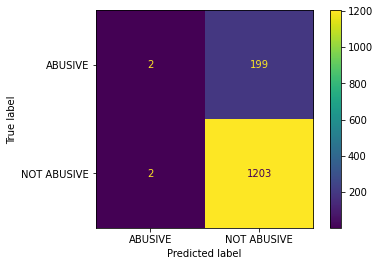

Split  2
- Accuracy: 0.8584637268847796
- MacroF1: 0.49457989439780914
- Precision: 0.7482893450635386
- Recall: 0.515665603105161


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


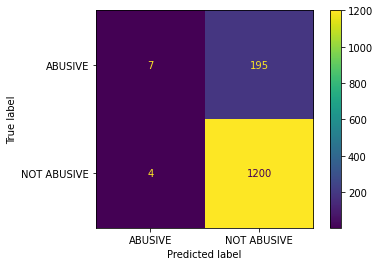

Split  3
- Accuracy: 0.8584637268847796
- MacroF1: 0.4811278941463369
- Precision: 0.8293361884368309
- Recall: 0.5094857077069833


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


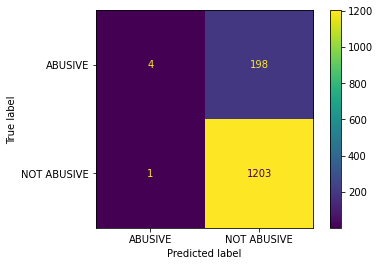

Split  4
- Accuracy: 0.8633451957295374
- MacroF1: 0.5144218999755195
- Precision: 0.8548297966401415
- Recall: 0.5265326192955488


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


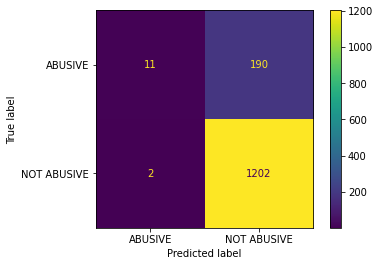

Split  5
- Accuracy: 0.8583629893238434
- MacroF1: 0.4810985466416491
- Precision: 0.7629258994519895
- Recall: 0.5091196839721658


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


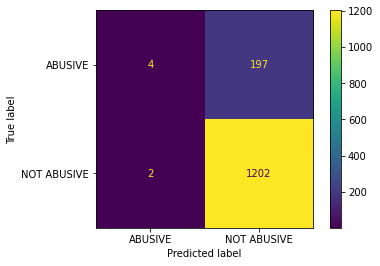

In [ ]:
#Import the model
from sklearn.naive_bayes import MultinomialNB

#Initialization of dictionary for metrics' results
model_scores["multinomial-naive-bayes"] = {}
model_scores["multinomial-naive-bayes"]["accuracy"] = {}
model_scores["multinomial-naive-bayes"]["macro_f1"] = {}
model_scores["multinomial-naive-bayes"]["precision"] = {}
model_scores["multinomial-naive-bayes"]["recall"] = {}

#Fit the model to each split
for j in range(K_SPLITS):
  model = MultinomialNB().fit(X_training[j], y_training[j])

  #Obtain predictions
  y_pred = model.predict(X_test[j])

  #Make comparisons to actual values
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average="macro")
  precision = precision_score(y_test[j], y_pred, average="macro")
  recall = recall_score(y_test[j], y_pred, average="macro")

  #Print the metrics' results for each split
  print("Split ", j+1)
  print(f"- Accuracy: {accuracy}")
  print(f"- MacroF1: {macro_f1}")
  print(f"- Precision: {precision}")
  print(f"- Recall: {recall}")

  #Plot a confusion matrix for errors visualization
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["multinomial-naive-bayes"]["accuracy"]) == 0:
    model_scores["multinomial-naive-bayes"]["accuracy"] = [accuracy]
    model_scores["multinomial-naive-bayes"]["macro_f1"] = [macro_f1]
    model_scores["multinomial-naive-bayes"]["precision"] = [precision]
    model_scores["multinomial-naive-bayes"]["recall"] = [recall]
  else:
    model_scores["multinomial-naive-bayes"]["accuracy"].append(accuracy)
    model_scores["multinomial-naive-bayes"]["macro_f1"].append(macro_f1)
    model_scores["multinomial-naive-bayes"]["precision"].append(precision)
    model_scores["multinomial-naive-bayes"]["recall"].append(recall)



## Linear Support Vector Machine 

Split  1
- Accuracy: 0.8314366998577525
- MacroF1: 0.6025249687778449
- Precision: 0.625634343711425
- Recall: 0.5907660865795504


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


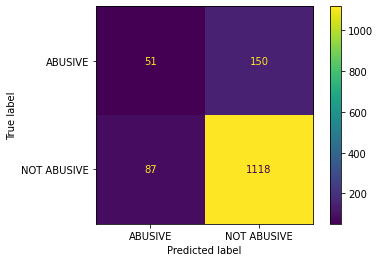

Split  2
- Accuracy: 0.8321479374110953
- MacroF1: 0.6293536006148099
- Precision: 0.6430177526412946
- Recall: 0.6197781322982797


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


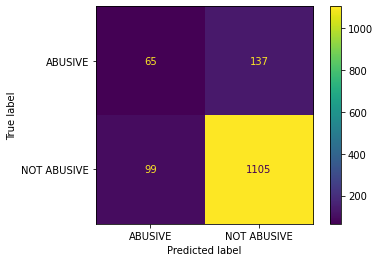

Split  3
- Accuracy: 0.8257467994310099
- MacroF1: 0.6050720276072389
- Precision: 0.6210793442144082
- Recall: 0.5954409394427815


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


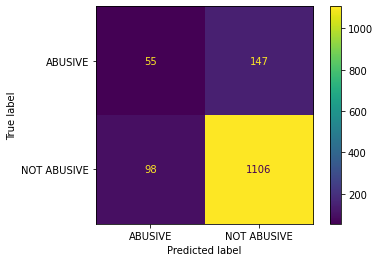

Split  4
- Accuracy: 0.8519572953736655
- MacroF1: 0.6589073456772832
- Precision: 0.6860284654402301
- Recall: 0.6421526090477844


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


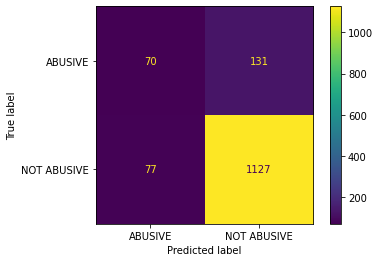

Split  5
- Accuracy: 0.8249110320284697
- MacroF1: 0.615392319196667
- Precision: 0.6260919195534618
- Recall: 0.6077213599775211


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


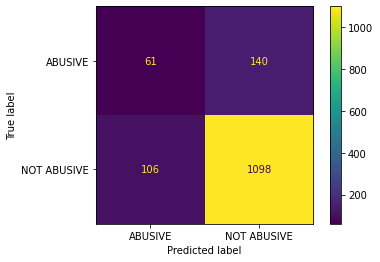

In [ ]:
#Import the model
from sklearn.svm import LinearSVC

#Initialization of dictionary for metrics' results
model_scores["linear-svc"] = {}
model_scores["linear-svc"]["accuracy"] = {}
model_scores["linear-svc"]["macro_f1"] = {}
model_scores["linear-svc"]["precision"] = {}
model_scores["linear-svc"]["recall"] = {}

#Fit the model to each split
for j in range(K_SPLITS):
  model = LinearSVC().fit(X_training[j], y_training[j])

  #Obtain predictions
  y_pred = model.predict(X_test[j])

  #Make comparisons to actual values
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average="macro")
  precision = precision_score(y_test[j], y_pred, average="macro")
  recall = recall_score(y_test[j], y_pred, average="macro")


  #Print the metrics' results for each split
  print("Split ", j+1)
  print(f"- Accuracy: {accuracy}")
  print(f"- MacroF1: {macro_f1}")
  print(f"- Precision: {precision}")
  print(f"- Recall: {recall}")


  #Plot a confusion matrix for errors visualization
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["linear-svc"]["accuracy"]) == 0:
    model_scores["linear-svc"]["accuracy"] = [accuracy]
    model_scores["linear-svc"]["macro_f1"] = [macro_f1]
    model_scores["linear-svc"]["precision"] = [precision]
    model_scores["linear-svc"]["recall"] = [recall]

  else:
    model_scores["linear-svc"]["accuracy"].append(accuracy)
    model_scores["linear-svc"]["macro_f1"].append(macro_f1)
    model_scores["linear-svc"]["precision"].append(precision)
    model_scores["linear-svc"]["recall"].append(recall)


## Decision Tree Classifier

Split  1
- Accuracy: 0.8200568990042674
- MacroF1: 0.579960017334481
- Precision: 0.5967418434658585
- Recall: 0.571691335851861


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


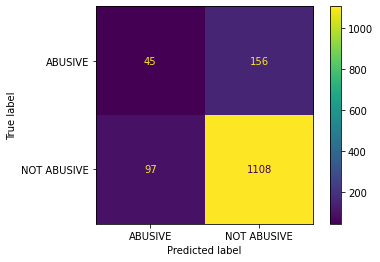

Split  2
- Accuracy: 0.8200568990042674
- MacroF1: 0.5756912113957585
- Precision: 0.5942865524322273
- Recall: 0.5673990987138581


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


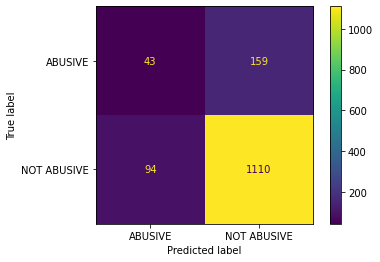

Split  3
- Accuracy: 0.8172119487908962
- MacroF1: 0.5645406395555529
- Precision: 0.5825945460666592
- Recall: 0.5574981086148482


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


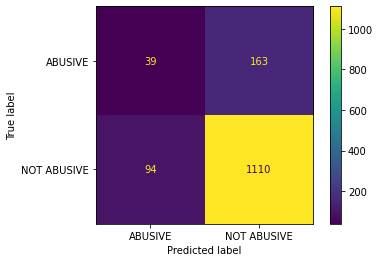

Split  4
- Accuracy: 0.8135231316725978
- MacroF1: 0.5826417233560092
- Precision: 0.5930928657237752
- Recall: 0.576209484140758


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


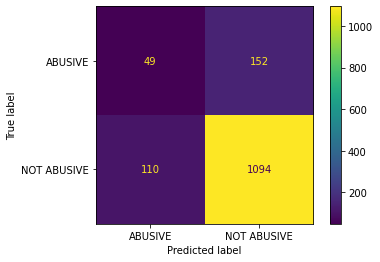

Split  5
- Accuracy: 0.8135231316725978
- MacroF1: 0.5724622531939605
- Precision: 0.5851510067114094
- Recall: 0.5658480851556172


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


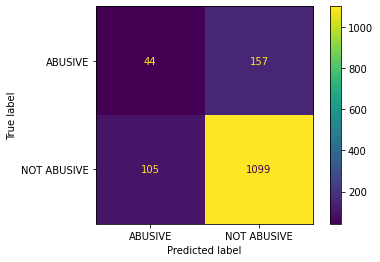

In [ ]:
#Import the model
from sklearn.tree import DecisionTreeClassifier as clf

#Initialization of dictionary for metrics' results
model_scores["decision-tree"] = {}
model_scores["decision-tree"]["accuracy"] = {}
model_scores["decision-tree"]["macro_f1"] = {}
model_scores["decision-tree"]["precision"] = {}
model_scores["decision-tree"]["recall"] = {}


#Fit the model to each split
for j in range(K_SPLITS):
  model = clf().fit(X_training[j], y_training[j])

  #Obtain predictions
  y_pred = model.predict(X_test[j])

  #Make comparisons to actual values
  accuracy = accuracy_score(y_test[j], y_pred)
  macro_f1 = f1_score(y_test[j], y_pred, average="macro")
  precision = precision_score(y_test[j], y_pred, average="macro")
  recall = recall_score(y_test[j], y_pred, average="macro")


  #Print the metrics' results for each split
  print("Split ", j+1)
  print(f"- Accuracy: {accuracy}")
  print(f"- MacroF1: {macro_f1}")
  print(f"- Precision: {precision}")
  print(f"- Recall: {recall}")


  #Plot a confusion matrix for errors visualization
  plot_confusion_matrix(model, X_test[j], y_test[j])  
  plt.show()

  # Add results to the results dictionary
  if len(model_scores["decision-tree"]["accuracy"]) == 0:
    model_scores["decision-tree"]["accuracy"] = [accuracy]
    model_scores["decision-tree"]["macro_f1"] = [macro_f1]
    model_scores["decision-tree"]["precision"] = [precision]
    model_scores["decision-tree"]["recall"] = [recall]

  else:
    model_scores["decision-tree"]["accuracy"].append(accuracy)
    model_scores["decision-tree"]["macro_f1"].append(macro_f1)
    model_scores["decision-tree"]["precision"].append(precision)
    model_scores["decision-tree"]["recall"].append(recall)


# Models comparison

Here we compare the performance of the diverse classifiers we experimented with.

In [ ]:
# Create dictionaries per metric
accuracy_dict = dict()
macro_f1_dict = dict()
precision_dict = dict()
recall_dict = dict()

for name, value in model_scores.items():
  accuracy_dict[name] = value["accuracy"]
  macro_f1_dict[name] = value["macro_f1"]
  precision_dict[name] = value["precision"]
  recall_dict[name] = value["recall"]

#Calculate average performance for each method and their deviation standard. Then, print the results

import numpy as np

# Accuracy means and standard deviations
means_accuracy = dict()
stand_dev_accuracy = dict()

for key in accuracy_dict:
  means_accuracy[key] = sum(accuracy_dict[key]) / len(accuracy_dict[key])
for key in accuracy_dict:
  stand_dev_accuracy[key] = np.std(accuracy_dict[key])

print("Accuracy Mean:")
for key, value in means_accuracy.items():
  print(key, value, end="\n")
print("\n")

print("Accuracy Deviation Standard:")
for key, value in stand_dev_accuracy.items():
  print(key, value, end="\n")
print("\n")

# Macro f1 means and standard deviations
means_macro_f1 = dict()
stand_dev_macro_f1 = dict()

for key in macro_f1_dict:
  means_macro_f1[key] = sum(macro_f1_dict[key]) / len(macro_f1_dict[key])
for key in macro_f1_dict:
  stand_dev_macro_f1[key] = np.std(macro_f1_dict[key])

print("Macro F1 Mean")
for key, value in means_macro_f1.items():
  print(key, value, end="\n")
print("\n")

print("Macro F1 Deviation Standard")
for key, value in stand_dev_macro_f1.items():
  print(key, value, end="\n")
print("\n")

#Precision means and standard deviation
means_precision = dict()
stand_dev_precision = dict()

for key in precision_dict:
  means_precision[key] = sum(precision_dict[key]) / len(precision_dict[key])
for key in precision_dict:
  stand_dev_precision[key] = np.std(precision_dict[key])

print("Precision Mean")
for key, value in means_precision.items():
  print(key, value, end="\n")
print("\n")

print("Precision Deviation Standard")
for key, value in stand_dev_precision.items():
  print(key, value, end="\n")
print("\n")

#Recall means and standard deviation
means_recall = dict()
stand_dev_recall = dict()

for key in recall_dict:
  means_recall[key] = sum(recall_dict[key]) / len(recall_dict[key])
for key in recall_dict:
  stand_dev_recall[key] = np.std(recall_dict[key])

print("Recall Mean")
for key, value in means_recall.items():
  print(key, value, end="\n")
print("\n")

print("Recall Deviation Standard")
for key, value in stand_dev_recall.items():
  print(key, value, end="\n")
print("\n")

Accuracy Mean:
always-abusive 0.14328394324273702
always-not-abusive 0.856716056757263
random 0.49643996496965215
logistic-regression 0.8528748677503126
multinomial-naive-bayes 0.8591353781202067
linear-svc 0.8332399528203986
decision-tree 0.8168744020289254


Accuracy Deviation Standard:
always-abusive 0.0003173845715182053
always-not-abusive 0.0003173845715181975
random 0.013447257153005971
logistic-regression 0.006340460687720975
multinomial-naive-bayes 0.002172866524083372
linear-svc 0.009801034643678347
decision-tree 0.0029268596760021995


Macro F1 Mean
always-abusive 0.12532657965792268
always-not-abusive 0.46141467049714446
random 0.42665500464285094
logistic-regression 0.5997925239233061
multinomial-naive-bayes 0.4884868550369782
linear-svc 0.6222500523747689
decision-tree 0.5750591689671524


Macro F1 Deviation Standard
always-abusive 0.0002427915825394657
always-not-abusive 9.207080550601245e-05
random 0.013777629781214567
logistic-regression 0.017319641080544276
multinomial

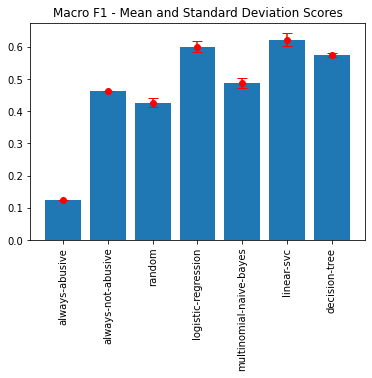

In [ ]:
# Plot the macro f1 scores
plt.title("Macro F1 - Mean and Standard Deviation Scores")
plt.bar(range(len(means_macro_f1)), list(means_macro_f1.values()), align='center')
plt.errorbar(range(len(means_macro_f1)), list(means_macro_f1.values()), yerr=stand_dev_macro_f1.values(), capsize=5, fmt="o", color="r")
plt.xticks(range(len(means_macro_f1)), list(means_macro_f1.keys()))
plt.xticks(rotation = 90)
plt.show()